<a href="https://colab.research.google.com/github/jeffrinrozario/TimeSeries/blob/main/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np

# 2. Define parameters for the synthetic time series data
n_timesteps = 2000
frequency = 0.05  # Controls how many cycles are in the data
amplitude = 10
noise_std = 1.5   # Standard deviation for noise

# 3. Generate a time array
time = np.arange(n_timesteps)

# 4. Create a sine wave
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

# 5. Add Gaussian noise to the sine wave
noise = np.random.normal(loc=0, scale=noise_std, size=n_timesteps)
data = sine_wave + noise

# 6. Store the generated time series data in a variable
# 'data' already holds the generated time series

# 7. Split the data into training and testing sets (80% train, 20% test)
train_size = int(n_timesteps * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# 8. Define a function to create sequences
def create_sequences(dataset, n_input_steps, n_output_steps):
    X, y = [], []
    for i in range(len(dataset) - n_input_steps - n_output_steps + 1):
        # Input sequence: n_input_steps consecutive values
        seq_in = dataset[i:(i + n_input_steps)]
        # Target sequence: subsequent n_output_steps values
        seq_out = dataset[i + n_input_steps : i + n_input_steps + n_output_steps]
        X.append(seq_in)
        y.append(seq_out)
    return np.array(X), np.array(y)

# Define input and output steps for the neural network
n_input_steps = 10  # Number of past timesteps to use as input
n_output_steps = 1  # Number of future timesteps to predict

# 10. Apply the create_sequences function to both train_data and test_data
X_train, y_train = create_sequences(train_data, n_input_steps, n_output_steps)
X_test, y_test = create_sequences(test_data, n_input_steps, n_output_steps)

# 11. Reshape X_train, y_train, X_test, and y_test to be 3D arrays
# (samples, timesteps, features). Since our time series is univariate, features will be 1.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print(f"Original data shape: {data.shape}")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Original data shape: (2000,)
Train data shape: (1600,)
Test data shape: (400,)
X_train shape: (1590, 10, 1)
y_train shape: (1590, 1, 1)
X_test shape: (390, 10, 1)
y_test shape: (390, 1, 1)


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate, Reshape
from tensorflow.keras.models import Model

# Assuming n_input_steps and n_output_steps are already defined from previous steps
# n_input_steps = 10
# n_output_steps = 1
# Number of features is 1 for our univariate time series
n_features = 1

# 2. Define the input shape for the model
encoder_inputs = Input(shape=(n_input_steps, n_features))

# 3. Create an encoder part of the model using an LSTM layer
# Ensure it returns sequences so that the attention mechanism can access each hidden state.
encoder_lstm = LSTM(units=64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We will use the last hidden state (state_h) for the context and initial decoder state
# For attention, we need all encoder_outputs (hidden states at each timestep)

# 4. Implement the attention mechanism
# a. Use a Dense layer on the encoder output to transform the hidden states
attention_dense_1 = Dense(units=64, activation='tanh')(encoder_outputs)

# b. Use another Dense layer to create 'energy' scores
attention_scores = Dense(units=1, activation='relu')(attention_dense_1)

# c. Apply a softmax activation to these energy scores to get attention weights
attention_weights = Activation('softmax')(attention_scores)

# d. Use a Dot layer to calculate the context vector
# The context vector is the weighted sum of the encoder outputs
context_vector = Dot(axes=1)([attention_weights, encoder_outputs])

# Reshape state_h to match the rank of context_vector for concatenation
# context_vector shape: (None, 1, 64)
# state_h shape: (None, 64)
# We need to reshape state_h to (None, 1, 64)
reshaped_state_h = Reshape((1, 64))(state_h)

# 5. Concatenate the context vector with the reshaped last hidden state of the LSTM
decoder_input = Concatenate(axis=-1)([context_vector, reshaped_state_h])

# 6. Use one or more Dense layers for the decoder to predict the n_output_steps future values
# The final Dense layer should have n_output_steps units.
decoder_dense_1 = Dense(units=64, activation='relu')(decoder_input)
decoder_outputs = Dense(units=n_output_steps)(decoder_dense_1)

# Create the model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# 7. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Print a summary of the model
print(model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 10, 64),  │     16,896 │ input_layer_4[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10, 64)    │      4,160 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10, 1)     │         65 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 1)     │          0 │ dense_13[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 1, 64)     │          0 │ activation_3[0][… │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 64)     │          0 │ lstm_4[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1, 128)    │          0 │ dot_3[0][0],      │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1, 64)     │      8,256 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1, 1)      │         65 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,442 (115.01 KB)

 Trainable params: 29,442 (115.01 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 26.4859 - val_loss: 3.5054
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9516 - val_loss: 2.7746
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6922 - val_loss: 2.7856
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7321 - val_loss: 3.3212
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8959 - val_loss: 2.7230
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7756 - val_loss: 3.3456
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7133 - val_loss: 2.9282
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6858 - val_loss: 2.7280
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5684 - val_loss: 3.1426
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.7489 - val_loss: 2.6529
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7368 - val_loss: 2.7544
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6704 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


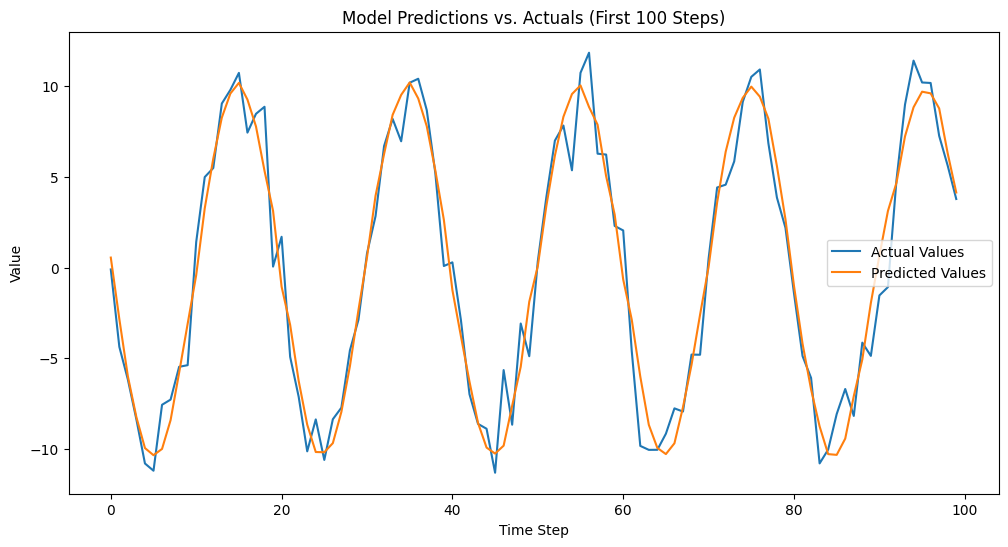

In [10]:
import matplotlib.pyplot as plt

# 1. Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# 2. Evaluate the trained model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {loss:.4f}')

# 3. Make predictions on X_test
predictions = model.predict(X_test)

# 4. Flatten y_test and predictions to 1D arrays for plotting
# Since n_output_steps is 1, the shape is (samples, 1, 1). We need (samples,).
actual_values = y_test[:, 0, 0]
predicted_values = predictions[:, 0, 0]

# 5. Create a plot showing a subset of the actual y_test values and the corresponding predicted values.
# For example, plot the first 100 actual values against the first 100 predicted values.
plot_range = 100
plt.figure(figsize=(12, 6))
plt.plot(actual_values[:plot_range], label='Actual Values')
plt.plot(predicted_values[:plot_range], label='Predicted Values')

# 6. Add a title to the plot
plt.title('Model Predictions vs. Actuals (First 100 Steps)')

# 7. Add a legend to distinguish between actual and predicted values
plt.legend()

# 8. Label the x-axis and y-axis
plt.xlabel('Time Step')
plt.ylabel('Value')

# 9. Display the plot
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Concatenate, Reshape, Softmax
from tensorflow.keras.models import Model

# Assuming n_input_steps and n_output_steps are already defined from previous steps
# n_input_steps = 10
# n_output_steps = 1
# Number of features is 1 for our univariate time series
n_features = 1

# 2. Define the input shape for the model
encoder_inputs = Input(shape=(n_input_steps, n_features))

# 3. Create an encoder part of the model using an LSTM layer
# Ensure it returns sequences so that the attention mechanism can access each hidden state.
encoder_lstm = LSTM(units=64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We will use the last hidden state (state_h) for the context and initial decoder state
# For attention, we need all encoder_outputs (hidden states at each timestep)

# 4. Implement the attention mechanism
# a. Use a Dense layer on the encoder output to transform the hidden states
attention_dense_1 = Dense(units=64, activation='tanh')(encoder_outputs)

# b. Use another Dense layer to create 'energy' scores
attention_scores = Dense(units=1, activation='relu')(attention_dense_1)

# c. Apply a softmax activation to these energy scores to get attention weights
# Corrected: Use Softmax layer with axis=1 to apply softmax across the time steps.
attention_weights = Softmax(axis=1)(attention_scores)

# d. Use a Dot layer to calculate the context vector
# The context vector is the weighted sum of the encoder outputs
context_vector = Dot(axes=1)([attention_weights, encoder_outputs])

# Reshape state_h to match the rank of context_vector for concatenation
# context_vector shape: (None, 1, 64)
# state_h shape: (None, 64)
# We need to reshape state_h to (None, 1, 64)
reshaped_state_h = Reshape((1, 64))(state_h)

# 5. Concatenate the context vector with the reshaped last hidden state of the LSTM
decoder_input = Concatenate(axis=-1)([context_vector, reshaped_state_h])

# 6. Use one or more Dense layers for the decoder to predict the n_output_steps future values
# The final Dense layer should have n_output_steps units.
decoder_dense_1 = Dense(units=64, activation='relu')(decoder_input)
decoder_outputs = Dense(units=n_output_steps)(decoder_dense_1)

# Create the model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# 7. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Print a summary of the model
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 10, 64),  │     16,896 │ input_layer_5[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 10, 64)    │      4,160 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 10, 1)     │         65 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 10, 1)     │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 1, 64)     │          0 │ softmax_1[0][0],  │
│                     │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 64)     │          0 │ lstm_5[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 1, 128)    │          0 │ dot_4[0][0],      │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1, 64)     │      8,256 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1, 1)      │         65 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,442 (115.01 KB)

 Trainable params: 29,442 (115.01 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 36.3803 - val_loss: 3.2506
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0835 - val_loss: 2.7496
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7197 - val_loss: 2.6886
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6675 - val_loss: 2.6561
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5066 - val_loss: 2.7197
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7313 - val_loss: 2.6799
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6704 - val_loss: 2.8143
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5933 - val_loss: 2.6866
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4800 - val_loss: 2.6689
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3933 - val_loss: 2.6525
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5940 - val_loss: 2.8092
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.

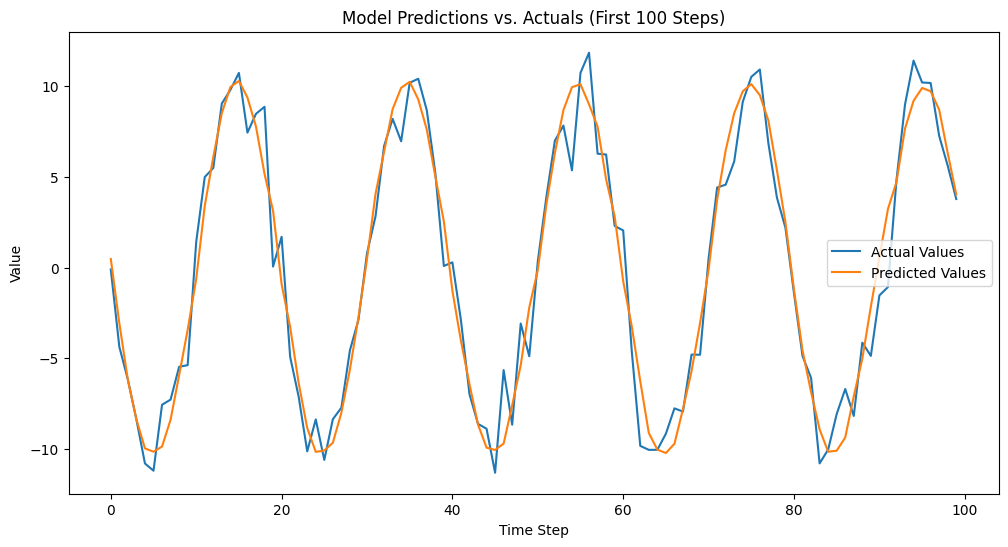

In [12]:
import matplotlib.pyplot as plt

# 1. Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# 2. Evaluate the trained model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {loss:.4f}')

# 3. Make predictions on X_test
predictions = model.predict(X_test)

# 4. Flatten y_test and predictions to 1D arrays for plotting
# Since n_output_steps is 1, the shape is (samples, 1, 1). We need (samples,).
actual_values = y_test[:, 0, 0]
predicted_values = predictions[:, 0, 0]

# 5. Create a plot showing a subset of the actual y_test values and the corresponding predicted values.
# For example, plot the first 100 actual values against the first 100 predicted values.
plot_range = 100
plt.figure(figsize=(12, 6))
plt.plot(actual_values[:plot_range], label='Actual Values')
plt.plot(predicted_values[:plot_range], label='Predicted Values')

# 6. Add a title to the plot
plt.title('Model Predictions vs. Actuals (First 100 Steps)')

# 7. Add a legend to distinguish between actual and predicted values
plt.legend()

# 8. Label the x-axis and y-axis
plt.xlabel('Time Step')
plt.ylabel('Value')

# 9. Display the plot
plt.show()